## Import Packages

In [24]:
import nba_api.stats.endpoints as nba
import nba_api as static
import config
import pandas as pd
import mysql_helper
import mysql.connector

## Connect to Database

### MySQL Connection

In [25]:
dbname = "nba"
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname)
cursor = cnx.cursor(buffered=True)

### Also connect to the database using the mysql_helper module which will allow database creation and insertion directly from dataframes

In [26]:
flatiron = mysql_helper.Connection(config.host, config.user, config.password)
nba_db = mysql_helper.DataBase(flatiron, 'nba')

## Retrieve game logs from NBA API

In [27]:
# Update headers to match new requirements by stats API--as of January 29, 2019
headers = {'Host': 'stats.nba.com', 
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:72.0) Gecko/20100101 Firefox/72.0', 
           'Accept': 'application/json, text/plain, */*', 
           'Accept-Language': 'en-US,en;q=0.5', 
           'Accept-Encoding': 'gzip, deflate, br', 
           'x-nba-stats-origin': 'stats', 
           'x-nba-stats-token': 'true', 
           'Connection': 'keep-alive', 
           'Referer': 'https://stats.nba.com/', 
           'Pragma': 'no-cache', 
           'Cache-Control': 'no-cache'}

### Define function to get the game logs for a given season

In [28]:
def get_game_logs(year):
    next_ = str(int(year)+1)[-2]
    df = nba.LeagueGameLog(season=year + '-' + next_, headers=headers).get_data_frames()[0]
    return df

### Retrieve the game logs for the 2017, 2018, and 2019 seasons

In [29]:
seasons = ['2017', '2018', '2019']
dfs = []
for season in seasons:
    dfs.append(get_game_logs(season))
total_logs = pd.concat(dfs)

In [30]:
total_logs.tail()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
1407,22019,1610612738,BOS,Boston Celtics,0021900701,2020-01-28,BOS @ MIA,W,240,39,...,37,48,24,5,8,14,22,109,8,1
1408,22019,1610612749,MIL,Milwaukee Bucks,0021900705,2020-01-28,MIL vs. WAS,W,240,50,...,35,46,31,3,3,15,26,151,20,1
1409,22019,1610612764,WAS,Washington Wizards,0021900705,2020-01-28,WAS @ MIL,L,240,44,...,24,35,28,6,6,11,27,131,-20,1
1410,22019,1610612756,PHX,Phoenix Suns,0021900706,2020-01-28,PHX @ DAL,W,240,51,...,31,39,34,10,4,13,25,133,29,1
1411,22019,1610612742,DAL,Dallas Mavericks,0021900706,2020-01-28,DAL vs. PHX,L,240,37,...,25,33,19,6,1,17,18,104,-29,1


## Insert into database

### Create the primary key for the game_log table

In [31]:
total_logs['pk'] = total_logs['GAME_ID']+total_logs['TEAM_ABBREVIATION']

In [18]:
total_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5390 entries, 0 to 469
Data columns (total 30 columns):
SEASON_ID            5390 non-null object
TEAM_ID              5390 non-null int64
TEAM_ABBREVIATION    5390 non-null object
TEAM_NAME            5390 non-null object
GAME_ID              5390 non-null object
GAME_DATE            5390 non-null object
MATCHUP              5390 non-null object
WL                   5388 non-null object
MIN                  5390 non-null int64
FGM                  5390 non-null int64
FGA                  5390 non-null int64
FG_PCT               5390 non-null float64
FG3M                 5390 non-null int64
FG3A                 5390 non-null int64
FG3_PCT              5390 non-null float64
FTM                  5390 non-null int64
FTA                  5390 non-null int64
FT_PCT               5390 non-null float64
OREB                 5390 non-null int64
DREB                 5390 non-null int64
REB                  5390 non-null int64
AST                 

### Creat the game_logs table from the dataframe retrieved from the NBA API

In [19]:
nba_db.table_fromDf(total_logs,'game_logs', 'pk')

CREATE TABLE IF NOT EXISTS game_logs (SEASON_ID VARCHAR (250), TEAM_ID INT (64), TEAM_ABBREVIATION VARCHAR (250), TEAM_NAME VARCHAR (250), GAME_ID VARCHAR (250), GAME_DATE VARCHAR (250), MATCHUP VARCHAR (250), WL VARCHAR (250), MIN INT (64), FGM INT (64), FGA INT (64), FG_PCT FLOAT, FG3M INT (64), FG3A INT (64), FG3_PCT FLOAT, FTM INT (64), FTA INT (64), FT_PCT FLOAT, OREB INT (64), DREB INT (64), REB INT (64), AST INT (64), STL INT (64), BLK INT (64), TOV INT (64), PF INT (64), PTS INT (64), PLUS_MINUS INT (64), VIDEO_AVAILABLE INT (64), pk VARCHAR (250), PRIMARY KEY (pk));
Creating a new table
OK


## Box Scores Table

### Select all game IDs from the game_logs table to fetch the boxscores from these games

In [32]:
stmt = """SELECT GAME_ID from nba.box_score"""
cursor.execute(stmt)
ids = cursor.fetchall()

In [33]:
ids_df = pd.DataFrame(ids)
ids_df.columns = ['game_id']

### Use one game ID from the above dataframe to generate a box score to build the box_score table from

In [34]:
box_score = nba.BoxScoreTraditionalV2(game_id='0021900002', headers=headers).get_data_frames()[0]

### Create a primary key for each row, change the title of the column for turnovers because the existing one is an SQL keyword and drop the original column

In [35]:
box_score['pk'] = str(box_score['PLAYER_ID']) + box_score['GAME_ID']
box_score['TOS'] = box_score['TO']
box_score.drop('TO', axis=1, inplace=True)

In [36]:
box_score.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS'],
      dtype='object')

### Use the mysql_helper module to create the box_score table directly from the dataframe returned from the NBA api above, using the 'pk' column as the primary key

In [40]:
flatiron = mysql_helper.Connection(config.host, config.user, config.password)
nba_db = mysql_helper.DataBase(flatiron, 'nba')

In [50]:
nba_db.table_fromDf(box_score,'box_score', 'pk')

CREATE TABLE IF NOT EXISTS box_score (GAME_ID VARCHAR (250), TEAM_ID INT (64), TEAM_ABBREVIATION VARCHAR (250), TEAM_CITY VARCHAR (250), PLAYER_ID INT (64), PLAYER_NAME VARCHAR (250), START_POSITION VARCHAR (250), COMMENT VARCHAR (250), MIN VARCHAR (250), FGM FLOAT, FGA FLOAT, FG_PCT FLOAT, FG3M FLOAT, FG3A FLOAT, FG3_PCT FLOAT, FTM FLOAT, FTA FLOAT, FT_PCT FLOAT, OREB FLOAT, DREB FLOAT, REB FLOAT, AST FLOAT, STL FLOAT, BLK FLOAT, PF FLOAT, PTS FLOAT, PLUS_MINUS FLOAT, pk VARCHAR (250), TOS FLOAT, PRIMARY KEY (pk));
Creating a new table
OK


### Parse game ID to generate season ID to feed back into the database

In [190]:
stmt="""UPDATE nba.box_score
    SET SEASON_ID = "22019"
    WHERE SUBSTRING(GAME_ID, 1,5) = "00219"
    """
cursor.execute(stmt)
cnx.commit()

In [ ]:
stmt="""UPDATE nba.box_score
    SET SEASON_ID = "22018"
    WHERE SUBSTRING(GAME_ID, 1,5) = "00218"
    """
cursor.execute(stmt)
cnx.commit()

In [ ]:
stmt="""UPDATE nba.box_score
    SET SEASON_ID = "22017"
    WHERE SUBSTRING(GAME_ID, 1,5) = "00217"
    """
cursor.execute(stmt)
cnx.commit()

### Generate column in box_score table for the number of instances per game a player accumulates double digit pts, rebs, asts, stls, or blks

#### Add columns "doubles"

In [25]:
stmt = """ALTER TABLE nba.box_score
        ADD COLUMN doubles INT(1)"""
cursor.execute(stmt)

#### Update doubles columns

In [32]:
stmt = """UPDATE nba.box_score
        SET doubles = CAST(PTS > 9 AS SIGNED INTEGER) + CAST(AST > 9 AS SIGNED INTEGER) + CAST(BLK > 9 AS SIGNED INTEGER) + CAST(REB > 9 AS SIGNED INTEGER) + CAST(STL > 9 AS SIGNED INTEGER)"""
cursor.execute(stmt)
cnx.commit()

#### Add column for double double (DD)

In [ ]:
stmt = """ALTER TABLE nba.box_score
        ADD COLUMN DD INT(1)"""
cursor.execute(stmt)

#### Add columns for triple double (TD)

In [21]:
stmt = """ALTER TABLE nba.box_score
        ADD COLUMN TD INT(1)"""
cursor.execute(stmt)

#### Update DD and TD columns

In [33]:
stmt = """UPDATE nba.box_score
        SET DD = CASE WHEN doubles = 2 THEN 1
                ELSE 0
            END,
        TD = CASE WHEN doubles > 2 THEN 1
                ELSE 0
            END;"""
cursor.execute(stmt)
cnx.commit()

### Calculate DraftKing Fantasy Points for each player for each game https://www.draftkings.com/help/rules/nba

In [ ]:
stmt = """UPDATE nba.box_score
        SET DK_PTS = PTS + .5*FG3M + 1.25*REB + 1.5*AST + 2*STL + 2*BLK -.5*TOS + 1.5*DD + 3*TD"""
cursor.execute(stmt)
cnx.commit()

## Feature Engineering

In [37]:
stmt = """SELECT * FROM nba.box_score"""
cursor.execute(stmt)
box_score = cursor.fetchall()

In [38]:
field_names = [i[0] for i in cursor.description]
print(field_names)
print (len(field_names))
box_scores_df = pd.DataFrame(box_score, columns=field_names)

['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID', 'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk', 'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles']
34


In [39]:
box_scores_df.shape
box_scores_df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,PF,PTS,PLUS_MINUS,pk,TOS,SEASON_ID,DK_PTS,DD,TD,doubles
0,None,NaN,None,None,NaN,None,None,None,None,NaN,...,NaN,NaN,NaN,,NaN,22017,NaN,0.0,0.0,NaN
1,0021700001,1.610613e+09,CLE,Cleveland,101112.0,Channing Frye,,DNP - Coach's Decision,None,NaN,...,NaN,NaN,NaN,0021700001101112,NaN,22017,NaN,0.0,0.0,NaN
2,0021700001,1.610613e+09,CLE,Cleveland,101181.0,Jose Calderon,,DNP - Coach's Decision,None,NaN,...,NaN,NaN,NaN,0021700001101181,NaN,22017,NaN,0.0,0.0,NaN
3,0021700001,1.610613e+09,BOS,Boston,1626179.0,Terry Rozier,,,19:32,2.0,...,0.0,9.0,5.0,00217000011626179,0.0,22017,24.25,0.0,0.0,0.0
4,0021700001,1.610613e+09,CLE,Cleveland,1626224.0,Cedi Osman,,DNP - Coach's Decision,None,NaN,...,NaN,NaN,NaN,00217000011626224,NaN,22017,NaN,0.0,0.0,NaN


In [40]:
stmt = """SELECT * FROM nba.game_logs"""
cursor.execute(stmt)
game_logs = cursor.fetchall()

In [41]:
field_names = [i[0] for i in cursor.description]
print(field_names)
print (len(field_names))
game_logs_df = pd.DataFrame(game_logs, columns=field_names)

['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'pk']
30


In [42]:
game_logs_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE',
       'pk'],
      dtype='object')

In [43]:
game_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6224 entries, 0 to 6223
Data columns (total 30 columns):
SEASON_ID            6224 non-null object
TEAM_ID              6224 non-null int64
TEAM_ABBREVIATION    6224 non-null object
TEAM_NAME            6224 non-null object
GAME_ID              6224 non-null object
GAME_DATE            6224 non-null object
MATCHUP              6224 non-null object
WL                   6224 non-null object
MIN                  6224 non-null int64
FGM                  6224 non-null int64
FGA                  6224 non-null int64
FG_PCT               6224 non-null float64
FG3M                 6224 non-null int64
FG3A                 6224 non-null int64
FG3_PCT              6224 non-null float64
FTM                  6224 non-null int64
FTA                  6224 non-null int64
FT_PCT               6224 non-null float64
OREB                 6224 non-null int64
DREB                 6224 non-null int64
REB                  6224 non-null int64
AST                

### Append opponent statistics to each observation in box_scores

In [44]:
#### For each season, for every team, sort the schedule chronologically
#### Then for each game_id for each team in a season, 
#### find the opponents stat line from that game,
#### rename the columns for the opponent stats,
#### and create one row using each team's and their opponent's stats for each game

games = []
for season in set(game_logs_df['SEASON_ID']):
    for team in set(game_logs_df['TEAM_ID']):
        sched = game_logs_df[(game_logs_df['SEASON_ID']==season) & (game_logs_df['TEAM_ID']==team)]
        sched = sched.sort_values(by=['GAME_ID'])
        for game in set(sched['GAME_ID']):
            one_game = sched[sched['GAME_ID']==game]
            one_game.reset_index(inplace=True, drop=True)
            #### Find opponent's stat line for the same game
            opp = game_logs_df[(game_logs_df['GAME_ID']== game) & 
             (game_logs_df['TEAM_ABBREVIATION'] != str(sched.loc[:,'TEAM_ABBREVIATION'].values[0]))]
            opp.reset_index(inplace=True, drop=True)
            opp_cols = ['OPP_'+ col for col in opp.columns] 
            opp.columns = opp_cols
            #### Combine opponent stats and team stats for a game into one row
            comb = pd.concat([one_game,opp], axis=1)
            games.append(comb)


#### Combine all rows into a single dataframe

In [45]:
games_with_opp = pd.concat(games)
games_with_opp.reset_index(inplace=True, drop=True)

In [46]:
games_with_opp.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,OPP_REB,OPP_AST,OPP_STL,OPP_BLK,OPP_TOV,OPP_PF,OPP_PTS,OPP_PLUS_MINUS,OPP_VIDEO_AVAILABLE,OPP_pk
0,22017,1610612737,ATL,Atlanta Hawks,0021701021,2018-03-15,ATL vs. CHA,L,240,42,...,45,30,3,3,10,21,129,12,1,0021701021CHA
1,22017,1610612737,ATL,Atlanta Hawks,0021700739,2018-01-29,ATL vs. MIN,W,240,39,...,35,24,15,5,14,18,100,-5,1,0021700739MIN
2,22017,1610612737,ATL,Atlanta Hawks,0021700390,2017-12-10,ATL @ NYK,L,240,37,...,33,16,9,4,12,30,111,4,1,0021700390NYK
3,22017,1610612737,ATL,Atlanta Hawks,0021700038,2017-10-22,ATL @ BKN,L,240,32,...,51,27,12,8,18,27,116,12,1,0021700038BKN
4,22017,1610612737,ATL,Atlanta Hawks,0021700811,2018-02-08,ATL @ ORL,L,240,37,...,36,20,10,6,13,22,100,2,1,0021700811ORL


#### Calculate rolling opponent stats lagged one game to analyze impact of opponent

In [47]:
teams = []
for season in set(games_with_opp['SEASON_ID']):
    for team in set(games_with_opp['TEAM_ID']):
        sched = games_with_opp[(games_with_opp['SEASON_ID']==season) & (games_with_opp['TEAM_ID']==team)]
        sched = sched.sort_values(by=['GAME_ID'])
        sched['OPP_DK_PTS'] = sched['OPP_PTS'] + sched['OPP_FG3M']*.5 + sched['OPP_REB']*1.25 + sched['OPP_AST']*1.5 + sched['OPP_STL']* 2 + sched['OPP_BLK']*2 -sched['OPP_TOV']*.5
        sched['OPP_DK_PTS_TRAIL3']= sched['OPP_DK_PTS'].shift(1).rolling(3).mean()
        sched['OPP_TEAM_PTS_TRAIL3'] = sched['OPP_PTS'].shift(1).rolling(3).mean()
        sched['OPP_TEAM_PTS_TRAIL7'] = sched['OPP_PTS'].shift(1).rolling(7).mean()
        teams.append(sched)
        

In [48]:
all_teams = pd.concat(teams)

In [49]:
all_teams.shape, game_logs_df.shape

((6224, 64), (6224, 30))

### Create column for opponent

#### Define function to find opponent from matchup columns

In [50]:
def split_matchup(x):
    if '@' in x:
        return x[x.index('@')+1:].strip()
    else:
        return x[x.index('.')+1:].strip()

In [51]:

all_teams['OPP'] = all_teams['MATCHUP'].apply(lambda x: split_matchup(x))

In [52]:
all_teams.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,OPP_PF,OPP_PTS,OPP_PLUS_MINUS,OPP_VIDEO_AVAILABLE,OPP_pk,OPP_DK_PTS,OPP_DK_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL7,OPP
71,22017,1610612737,ATL,Atlanta Hawks,0021700009,2017-10-18,ATL @ DAL,W,240,48,...,19,111,-6,1,0021700009DAL,221.25,NaN,NaN,NaN,DAL
49,22017,1610612737,ATL,Atlanta Hawks,0021700017,2017-10-20,ATL @ CHA,L,240,36,...,18,109,18,1,0021700017CHA,218.75,NaN,NaN,NaN,CHA
3,22017,1610612737,ATL,Atlanta Hawks,0021700038,2017-10-22,ATL @ BKN,L,240,32,...,27,116,12,1,0021700038BKN,256.75,NaN,NaN,NaN,BKN
64,22017,1610612737,ATL,Atlanta Hawks,0021700042,2017-10-23,ATL @ MIA,L,240,36,...,19,104,11,1,0021700042MIA,220.25,232.250000,112.000000,NaN,MIA
48,22017,1610612737,ATL,Atlanta Hawks,0021700065,2017-10-26,ATL @ CHI,L,240,32,...,15,91,5,1,0021700065CHI,212.00,231.916667,109.666667,NaN,CHI


### Create function to generate rolling averages, shifted one game

In [53]:
import numpy as np
# Get average from last trail_len
def get_trailing_avg(df, col_name, trail_len):
    df.reset_index(inplace=True, drop=True)
    new_col = col_name + '_TRAIL' + str(trail_len)
    df[new_col] = None
    for i in range(0, trail_len):
        df.at[i, new_col] = 'game' + str(i + 1)
    for index in range(trail_len, len(df)):
        df.at[index, new_col] = np.mean(df.loc[index-trail_len:index-1, col_name])



In [54]:
box_scores_df.reset_index(inplace=True, drop=True)

In [55]:
box_scores_df.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles'],
      dtype='object')

### Use function to calculate trailing averages for game stats

In [56]:
boxes = []
for season in set(box_scores_df['SEASON_ID']):
    for player in set(box_scores_df['PLAYER_ID']):
        game = box_scores_df[(box_scores_df['SEASON_ID']==season) & (box_scores_df['PLAYER_ID']==player)]
        game = game.sort_values(by=['GAME_ID'])
        
        get_trailing_avg(game,'FGM', 3)
        get_trailing_avg(game,'FGA', 3)
        get_trailing_avg(game,'FG_PCT', 3)
        get_trailing_avg(game,'FG3M', 3)
        get_trailing_avg(game,'FG3A', 3)
        get_trailing_avg(game,'FG3_PCT', 3)
        get_trailing_avg(game,'FTM', 3)
        get_trailing_avg(game,'FTA', 3)
        get_trailing_avg(game,'FT_PCT', 3)
        get_trailing_avg(game,'OREB', 3)
        get_trailing_avg(game,'DREB', 3)
        get_trailing_avg(game,'REB', 3)
        get_trailing_avg(game,'AST', 3)
        get_trailing_avg(game,'STL', 3)
        get_trailing_avg(game,'BLK', 3) 
        get_trailing_avg(game,'PTS', 3) 
        get_trailing_avg(game,'TOS', 3)
        get_trailing_avg(game,'doubles', 3)
        boxes.append(game)

In [57]:
box_all = pd.concat(boxes)

In [58]:
box_all.shape

(82289, 52)

### Combine Box Scores with trailing stats with opponent stats

In [59]:
box_all.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'FGM_TRAIL3',
       'FGA_TRAIL3', 'FG_PCT_TRAIL3', 'FG3M_TRAIL3', 'FG3A_TRAIL3',
       'FG3_PCT_TRAIL3', 'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3',
       'OREB_TRAIL3', 'DREB_TRAIL3', 'REB_TRAIL3', 'AST_TRAIL3', 'STL_TRAIL3',
       'BLK_TRAIL3', 'PTS_TRAIL3', 'TOS_TRAIL3', 'doubles_TRAIL3'],
      dtype='object')

In [60]:
all_teams.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'pk',
       'OPP_SEASON_ID', 'OPP_TEAM_ID', 'OPP_TEAM_ABBREVIATION',
       'OPP_TEAM_NAME', 'OPP_GAME_ID', 'OPP_GAME_DATE', 'OPP_MATCHUP',
       'OPP_WL', 'OPP_MIN', 'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M',
       'OPP_FG3A', 'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT',
       'OPP_OREB', 'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK',
       'OPP_TOV', 'OPP_PF', 'OPP_PTS', 'OPP_PLUS_MINUS', 'OPP_VIDEO_AVAILABLE',
       'OPP_pk', 'OPP_DK_PTS', 'OPP_DK_PTS_TRAIL3', 'OPP_TEAM_PTS_TRAIL3',
       'OPP_TEAM_PTS_TRAIL7', 'OPP'],
      dtype='object')

#### Merge dataframes

In [61]:
# df1.merge(df2.rename(columns={'b':'a'}),how='outer')
df_master =pd.merge(box_all,all_teams, how='left',left_on=['GAME_ID'], right_on=['GAME_ID'])

In [62]:
df_master.dropna(inplace=True)

In [63]:
df_master.head(120)

,GAME_ID,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN_x,FGM_x,...,OPP_PF,OPP_PTS,OPP_PLUS_MINUS,OPP_VIDEO_AVAILABLE,OPP_pk,OPP_DK_PTS,OPP_DK_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL7,OPP
3,0021700498,1.610613e+09,DET,Detroit,202779.0,Dwight Buycks,,,2:10,0.0,...,17.0,107.0,24.0,1.0,0021700498DET,215.00,217.500000,108.666667,106.142857,DET
4,0021700498,1.610613e+09,DET,Detroit,202779.0,Dwight Buycks,,,2:10,0.0,...,19.0,83.0,-24.0,1.0,0021700498IND,157.50,221.833333,107.000000,100.571429,IND
5,0021700516,1.610613e+09,DET,Detroit,202779.0,Dwight Buycks,,,2:12,0.0,...,17.0,89.0,-13.0,1.0,0021700516DET,184.75,236.833333,116.000000,110.714286,DET
6,0021700516,1.610613e+09,DET,Detroit,202779.0,Dwight Buycks,,,2:12,0.0,...,17.0,102.0,13.0,1.0,0021700516ORL,217.00,200.833333,98.000000,99.428571,ORL
7,0021700530,1.610613e+09,DET,Detroit,202779.0,Dwight Buycks,,,17:34,2.0,...,11.0,93.0,14.0,1.0,0021700530DET,202.75,207.750000,101.000000,97.285714,DET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0021700251,1.610613e+09,DEN,Denver,1626144.0,Emmanuel Mudiay,,,19:39,1.0,...,19.0,98.0,-16.0,1.0,0021700251SAC,199.00,227.666667,113.333333,110.285714,SAC
278,0021700251,1.610613e+09,DEN,Denver,1626144.0,Emmanuel Mudiay,,,19:39,1.0,...,13.0,114.0,16.0,1.0,0021700251DEN,220.75,219.750000,103.333333,104.571429,DEN
279,0021700259,1.610613e+09,DEN,Denver,1626144.0,Emmanuel Mudiay,,,24:57,0.0,...,22.0,125.0,30.0,2.0,0021700259HOU,261.50,223.250000,113.000000,106.142857,HOU
280,0021700259,1.610613e+09,DEN,Denver,1626144.0,Emmanuel Mudiay,,,24:57,0.0,...,14.0,95.0,-30.0,2.0,0021700259DEN,203.75,227.250000,109.333333,106.000000,DEN


In [64]:
df_master.reset_index(inplace = True, drop = True)
df_master_opp = df_master[df_master['TEAM_ABBREVIATION_x'] == df_master['OPP']]

In [65]:
df_master_opp.iloc[0,:]

GAME_ID                 0021700498
TEAM_ID_x              1.61061e+09
TEAM_ABBREVIATION_x            DET
TEAM_CITY                  Detroit
PLAYER_ID                   202779
                          ...     
OPP_DK_PTS                     215
OPP_DK_PTS_TRAIL3            217.5
OPP_TEAM_PTS_TRAIL3        108.667
OPP_TEAM_PTS_TRAIL7        106.143
OPP                            DET
Name: 0, Length: 116, dtype: object

#### Calculate DraftKings points scored by each player

In [66]:
df_master_opp['DK_PTS'] = df_master_opp['PTS_x'] + df_master_opp['FG3M_x']*.5 + df_master_opp['REB_x']*1.25 + df_master_opp['AST_x']*1.5 + df_master_opp['STL_x']* 2 + df_master_opp['BLK_x']*2 -df_master_opp['TOS']*.5


/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


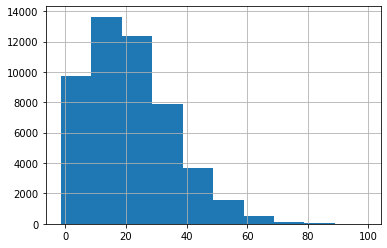

In [67]:
df_master_opp['DK_PTS'].hist()

### Correlation between opposing team's defense and amount of fantasy points a player scores

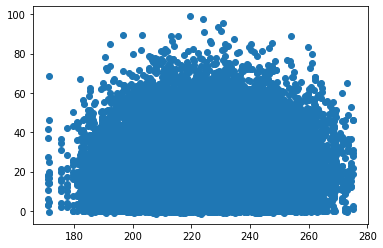

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

defense_df = df_master_opp[['OPP_DK_PTS_TRAIL3','DK_PTS']]

plt.scatter(defense_df.OPP_DK_PTS_TRAIL3, defense_df.DK_PTS)


In [70]:
defense_df.corr()

,OPP_DK_PTS_TRAIL3,DK_PTS
OPP_DK_PTS_TRAIL3,1.000000,0.040687
DK_PTS,0.040687,1.000000


#### Correlation with Power Transformed Variables

In [71]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
scaler.fit(defense_df)
defense_df_transformed = scaler.transform(defense_df)

In [72]:
defense_clean_transformed = pd.DataFrame(defense_df_transformed)

In [73]:
defense_clean_transformed.corr()

,0,1
0,1.000000,0.037706
1,0.037706,1.000000
